In [45]:
# Initialize Otter
import otter
grader = otter.Notebook("Project3.ipynb")

# Project 3 - Random Forest Classifer and Expected Goals (xG)

In this project you'll be using a Random Forest Classifier to train a model that predicts the probability of a goal ($y=1$) being scored in a soccer match based on where and how the shot was taken $X_{shot}$.
$$P(y=Goal | X_{shot})$$

In a game with $N$ shots expected goals (xG) is the sum over these probabilities.  

$$xG= \sum_{i=1}^{N} P_i(y=Goal | X_{shot,i})$$

* This metric is call 'expected' goals, because this is what you would expect the mean number of goals to be if this same game was played over and over again.
* The game has a total xG and each shot has it's own xG ( $P_i(y=Goal | X_{shot,i})$), both are used
* It's a useful indicator of how good a team is doing tactically, which is harder to do with the actual scores in soccer because soccer scores tend to be low, and hence more susceptible to random chance.
* We'll also use a new useful concept call 'calibration', which checks if our estimated probability is correct. I.e, if the classifier says $P(y=Goal | X_{shot})=0.2$ then 1 in 5  shots with this $X_{shot}$ should be goals, no more and no less. 

# Data

This data comes from  Stats Bomb https://github.com/statsbomb/open-data

<img src='https://upload.wikimedia.org/wikipedia/en/3/31/Hudlvideologo.png' width=200px>

* Train data - Several seasons of top league (US, Germany, England) and World Cup  Women's Soccer games
* Test Game - Portland Thorns vs. Utah Royals July 6th - [highlights](https://youtu.be/IRbTkHNXe4s?si=lBAinf5Zm_o98E6R)
* Test Season - Women's 2023 World-Cup

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from  sklearn.ensemble import  RandomForestClassifier
from sklearn.calibration import CalibrationDisplay
from scipy.stats import poisson_binom
import scipy,sklearn

In [47]:
# Helpful for grading
print("pandas:",pd.__version__)
print("scipy:",scipy.__version__)
print("sklearn:",sklearn.__version__)
print("numpy:",np.__version__)


pandas: 2.3.3
scipy: 1.17.0
sklearn: 1.8.0
numpy: 2.4.1


# Process Data
I've provided you as starting point for processing the data

In [48]:
input_df=pd.read_csv('xg_train.csv')
input_y=input_df['is_goal']
input_df=input_df.drop(columns=['is_goal'])
string_cols = input_df.select_dtypes(include=["object", "string"]).columns
numeric_cols = input_df.select_dtypes(include=["number"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), string_cols),
        ("num", StandardScaler(), numeric_cols)],    
        verbose_feature_names_out=False,
        remainder="drop",
        sparse_threshold=0,
)

X_processed = preprocess.fit_transform(input_df)
df_processed = pd.DataFrame(X_processed, columns=list(preprocess.get_feature_names_out()))


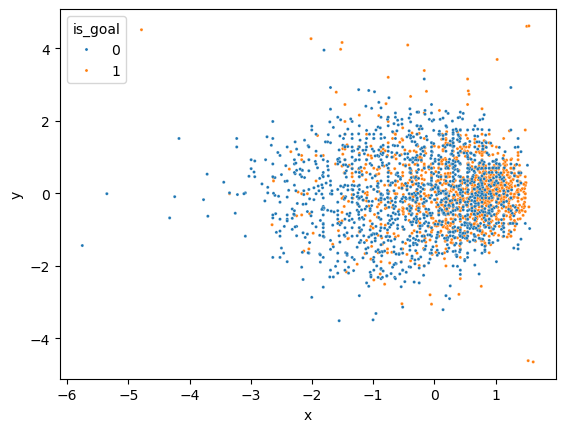

In [49]:
import seaborn as sns
sns.scatterplot(df_processed,x='x',y='y',hue=input_y,s=5)
plt.show()

# Task 1 Split Data (10-points)
We've done this a bunch of times, but I want you to go through all the steps here
* Split X_processed into X_train, X_test, y_train, y_test with a 20% split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, input_y, test_size=0.2)

In [51]:
grader.check("Task 1")

Task 1 results: All test cases passed!

# Calibration Concepts
Read the following to better understand the next task

## Expected Calibration Error (ECE)

**Expected Calibration Error (ECE)** measures how well a model’s predicted probabilities align with true empirical frequencies. 
### Definition

For each sample, take the predicted class and its associated probability (the **confidence**). Partition the interval \([0,1]\) into \(K\) bins. For each bin \(B_k\), compute:

- **rate(k)** = $1/N\sum_{i\in k} y_i$  
- **conf(k)** = $1/N\sum_{i\in k} \hat{y}_i$   
- **$|B_k| / N$** — the bin’s proportion of total samples

The ECE is the weighted sum of calibration gaps between bins:

$$
\text{ECE} = \sum_{k=1}^{K} \frac{|B_k|}{N} \left| \text{rate}(k) - \text{conf}(k) \right|.
$$

- Lower ECE → better calibration  
- ECE = 0 indicates perfect calibration

# Calibration Plots
We an also make 'Calibration Plots' that show this graphically, in these plots you want the model's output to be as close to the dotted straight line as possible. Anywhere the points are above the line means that the model is under-confident and there are more positives than expected. Anywhere the points are below the line means that the model is over-confident and there are less positives than expected.

<img src=https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_calibration_001.png>


In [52]:
# Caculate ece
def ece(y_true, y_prob):
    n_bins=10
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    assert y_prob.ndim == 1
    conf = y_prob    
    bins = np.linspace(0, 1, n_bins+1)
    b = np.digitize(conf, bins) - 1
    e = 0.
    for i in range(n_bins):
        m = b == i
        if m.any():
            e += m.mean() * abs(y_true[m].mean() - conf[m].mean())
    return e

# Task 2 Train a Model (20-points)

* Goal is to find the hyper-parameters that
    * Don't over fit
         * Train and test accuracy differ by less than 1.5%
    * Are well calibrated
        * Calibration plots for train and test are close to straight lines
        * ECE score for train and test less than 0.07
    * Accuracy at least 67% on both train and test


In [53]:
# Grid search to find optimal hyperparameters
max_depths = [3, 5, 7, 10, None]
min_samples_leafs = [1, 5, 10, 20, 50, 100]

print(f"{'max_depth':<10} {'min_samples_leaf':<20} {'Train Acc':<10} {'Test Acc':<10} {'Diff':<10} {'Train ECE':<10} {'Test ECE':<10}")

for md in max_depths:
    for msl in min_samples_leafs:
        # Train model with current hyperparameters
        model = RandomForestClassifier(n_estimators=100, max_depth=md, min_samples_leaf=msl, random_state=42)
        model.fit(X_train, y_train)
        
        # Get probabilities
        train_probs = model.predict_proba(X_train)[:, 1]
        test_probs = model.predict_proba(X_test)[:, 1]
        
        # Calculate accuracy
        train_acc = (y_train == (train_probs > 0.5)).mean()
        test_acc = (y_test == (test_probs > 0.5)).mean()
        
        # Calculate ECE
        train_ece = ece(y_train, train_probs)
        test_ece = ece(y_test, test_probs)
        
        # Calculate difference
        diff = abs(train_acc - test_acc)
        
        # Check constraints
        valid = (diff < 0.015) and (train_ece < 0.07) and (test_ece < 0.07) and (train_acc >= 0.67) and (test_acc >= 0.67)
        
        # Only print if valid
        if valid:
            print(f"{str(md):<10} {msl:<20} {train_acc:.4f}     {test_acc:.4f}     {diff:.4f}     {train_ece:.4f}     {test_ece:.4f}")

max_depth  min_samples_leaf     Train Acc  Test Acc   Diff       Train ECE  Test ECE  
3          1                    0.6864     0.6861     0.0003     0.0662     0.0605
3          5                    0.6864     0.6843     0.0021     0.0685     0.0584
5          5                    0.7053     0.6949     0.0105     0.0529     0.0404
5          10                   0.7080     0.6949     0.0131     0.0472     0.0521
5          20                   0.7014     0.6896     0.0118     0.0481     0.0525
5          50                   0.7000     0.6966     0.0034     0.0448     0.0496
5          100                  0.6890     0.6949     0.0059     0.0538     0.0509
7          50                   0.6996     0.7019     0.0023     0.0405     0.0568
7          100                  0.6903     0.6931     0.0028     0.0514     0.0514
10         50                   0.7036     0.7019     0.0016     0.0376     0.0527
10         100                  0.6903     0.6931     0.0028     0.0500     0.0513


In [54]:
hyper_parameters = {
    'max_depth': 3,
    'min_samples_leaf': 20,
    'n_estimators': 100,
    'random_state': 42
}

Train Accuracy 0.686369651521835 Train Accuracy 0.691358024691358
Train ECE 0.07026982098881623 Test 0.05850412843025994


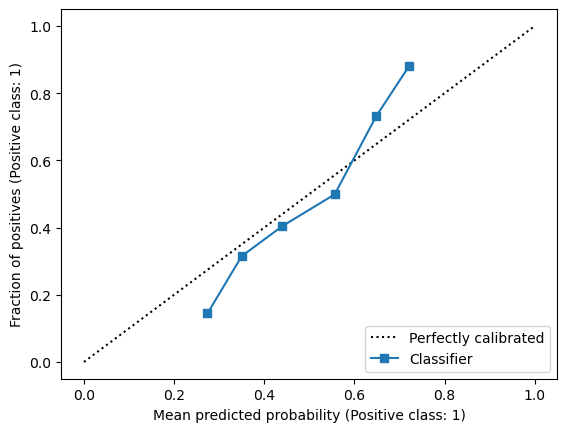

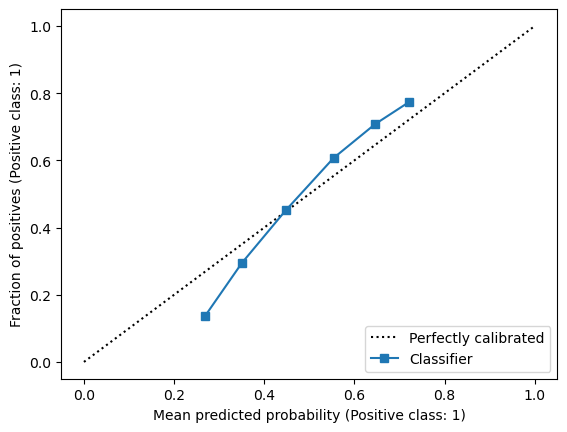

In [55]:
# Keep this code the same
model=RandomForestClassifier(**hyper_parameters)
res=model.fit(X_train,y_train)
train_probs=model.predict_proba(X_train)
test_probs=model.predict_proba(X_test)

train_acc=(y_train==(train_probs[:,1]>0.5)).mean()
test_acc=(y_test==(test_probs[:,1]>0.5)).mean()

train_ece=ece(y_train,train_probs[:,1])
test_ece=ece(y_test,test_probs[:,1])


CalibrationDisplay.from_predictions(y_train, train_probs[:,1],n_bins=10)
CalibrationDisplay.from_predictions(y_test, test_probs[:,1],n_bins=10)

print(f"Train Accuracy {train_acc} Train Accuracy {test_acc}")
print(f"Train ECE {train_ece} Test {test_ece}")

In [56]:
grader.check("Task 2")

Task 2 results:
    Task 2 - 1 result:
        ✅ Test case passed

    Task 2 - 2 result:
        ✅ Test case passed

    Task 2 - 3 result:
        ✅ Test case passed

    Task 2 - 4 result:
        ❌ Test case failed
        Trying:
            bool(train_ece < 0.07)
        Expecting:
            True
        **********************************************************************
        Line 1, in Task 2 3
        Failed example:
            bool(train_ece < 0.07)
        Expected:
            True
        Got:
            False

    Task 2 - 5 result:
        ✅ Test case passed

# Task 3 Apply This to a Test Game (10-points)
1. Use the same model trained above to predict the probabilities for each shot in the game
2. Assign this to a column name 'xG' in the test_game dataframe i.e. (test_game['xG']=probs)

In [57]:
test_game=pd.read_csv('test_game.csv')
display(test_game)

,Unnamed: 0,match_id,team,player,minute,second,x,y,shot_distance,shot_angle,body_part,technique,play_pattern,is_goal,competition_id,season_id
0,9154,7477,Portland Thorns,Tobin Powell Heath,1,0,103.0,36.0,17.464249,0.231091,Right Foot,Normal,Regular Play,1,49,3
1,9155,7477,Portland Thorns,Tobin Powell Heath,4,4,105.0,51.0,18.601075,0.632749,Left Foot,Half Volley,From Throw In,0,49,3
2,9156,7477,Utah Royals,Diana Matheson,9,24,103.0,33.0,18.384776,0.390607,Right Foot,Normal,From Throw In,0,49,3
3,9157,7477,Portland Thorns,Tobin Powell Heath,23,56,90.0,29.0,31.953091,0.351445,Right Foot,Normal,From Throw In,0,49,3
4,9158,7477,Portland Thorns,Hayley Emma Raso,27,42,94.0,36.0,26.305893,0.152649,Right Foot,Normal,Regular Play,0,49,3
5,9159,7477,Portland Thorns,Lindsey Michelle Horan,31,27,112.0,41.0,8.062258,0.124355,Head,Normal,From Free Kick,1,49,3
6,9160,7477,Portland Thorns,Ana-Maria Crnogorčević,33,21,107.0,47.0,14.764823,0.493941,Left Foot,Normal,From Counter,1,49,3
7,9161,7477,Portland Thorns,Hayley Emma Raso,45,10,107.0,45.0,13.928388,0.367174,Head,Normal,Regular Play,0,49,3
8,9162,7477,Utah Royals,Katrina Gorry,52,48,94.0,31.0,27.513633,0.333244,Left Foot,Normal,Regular Play,0,49,3
9,9163,7477,Portland Thorns,Ellie Madison Carpenter,55,25,89.0,66.0,40.459857,0.697903,Right Foot,Normal,Regular Play,0,49,3


In [58]:
# 1. Use the trained model to predict probabilities (the probability of class 1, which is a goal)
probs = model.predict_proba(preprocess.transform(test_game))[:, 1]

# 2. Assign this to a column name 'xG' in the test_game dataframe
test_game['xG'] = probs

# Display the result to confirm
display(test_game.head())

,Unnamed: 0,match_id,team,player,minute,second,x,y,shot_distance,shot_angle,body_part,technique,play_pattern,is_goal,competition_id,season_id,xG
0,9154,7477,Portland Thorns,Tobin Powell Heath,1,0,103.0,36.0,17.464249,0.231091,Right Foot,Normal,Regular Play,1,49,3,0.376122
1,9155,7477,Portland Thorns,Tobin Powell Heath,4,4,105.0,51.0,18.601075,0.632749,Left Foot,Half Volley,From Throw In,0,49,3,0.418617
2,9156,7477,Utah Royals,Diana Matheson,9,24,103.0,33.0,18.384776,0.390607,Right Foot,Normal,From Throw In,0,49,3,0.360215
3,9157,7477,Portland Thorns,Tobin Powell Heath,23,56,90.0,29.0,31.953091,0.351445,Right Foot,Normal,From Throw In,0,49,3,0.246789
4,9158,7477,Portland Thorns,Hayley Emma Raso,27,42,94.0,36.0,26.305893,0.152649,Right Foot,Normal,Regular Play,0,49,3,0.311716


In [59]:
grader.check("Task 3")

Task 3 results:
    Task 3 - 1 result:
        ✅ Test case passed

    Task 3 - 2 result:
        ✅ Test case passed

    Task 3 - 3 result:
        ❌ Test case failed
        Trying:
            np.sum(test_game['xG']) > 4 and np.sum(test_game['xG']) < 8
        Expecting:
            True
        **********************************************************************
        Line 1, in Task 3 2
        Failed example:
            np.sum(test_game['xG']) > 4 and np.sum(test_game['xG']) < 8
        Expected:
            True
        Got:
            np.True_

# Compare to the Real Game Results
Run the cell below to compare to the real game results

In [60]:
xg_res=test_game.groupby('team')[['xG','is_goal']].sum()
thorns_xg,thorns_goals=xg_res.loc['Portland Thorns'][['xG','is_goal']]
royals_xg,royals_goals=xg_res.loc['Utah Royals'][['xG','is_goal']]

print(f'Thorns xG ={round(thorns_xg,2)} goals {thorns_goals}')
print(f'Royals xG ={round(royals_xg,2)} goals {royals_goals}')


Thorns xG =3.93 goals 4.0
Royals xG =2.77 goals 0.0


# Did that work?

We want to know if our expected goals prediction is consistent with the observed goals (4-0 Thorns). How do we do this? 

## Poisson–Binomial Distribution

The **Poisson–binomial distribution** is the distribution of the sum of independent Bernoulli trials (coin flips) with (potentially) different success probabilities. Perfect for this exercise where each 'trial' is a shot with probability given by the model output (or xG)

We would say the game score $X$ is drawn from
$$X \sim \mathrm{PB}(p_1, p_2, \dots, p_n)$$

and we can caulate this using scipy's  `poisson_binom` and some of its useful functions.

 * **pmf** (Probability mass function) - in this case **pmf(N,probs)** is the likelihood of observing exactly N goas.
     * This great for individual games where there aren't too many possible outcomes 
 * **cdf** (Cumulative distribution function) -in this case **cdf(N,probs)** is the the likelihood of observing exactly N goals or less
     * This is helpful for looking a seasons where the odds of see 179, 180, and 181 goals are all similar and all small, and you want to check if your expected goals are too high (i.e. you observe less and want to know how rare seeing this observation or less is)
 * **sf**  (Survival Function (1-CDF)) distribution functions **cdf(N,probs)** is the the likelihood of observing exactly N goals or more
     * This is helpful for looking at the other side of the distribution observing to many.

### Run the cell below to get an estimate of how likely this game was

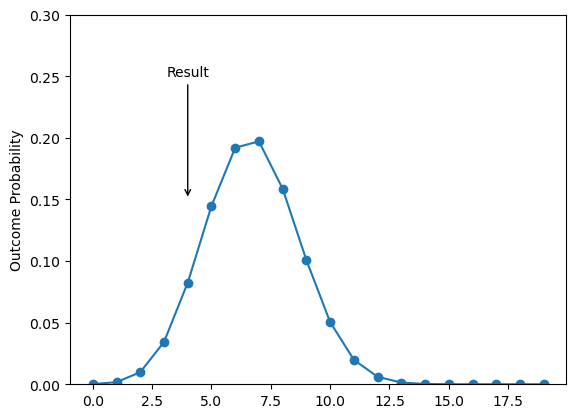

This number of goals would happen in 8.25% of games


In [61]:
all_goals=thorns_goals+royals_goals
x=range(0,20)
outcome_probs=[poisson_binom.pmf(i,test_game['xG'].values)  for i in x]
plt.plot(x,outcome_probs,'o-')
plt.ylabel('Outcome Probability')
plt.annotate('Result',(4,.15),xytext=(4,.25),horizontalalignment='center',arrowprops=dict(arrowstyle='->',))
plt.ylim(0,.3)
plt.show()
outcome_percent= round(outcome_probs[int(all_goals)]*100,2)
print(f'This number of goals would happen in {outcome_percent}% of games')

<!-- BEGIN QUESTION -->

# Task 3 question: Does This Result make sense? (10-pts)
Write a few sentences describing what you see above and what that means for the quality of your model

The observed result of 4 total goals falls within a plausible range of the Poisson-Binomial distribution generated by our xG model. The Portland Thorns' predicted xG of roughly 3.93 is extremely close to their actual 4 goals, indicating the model captures offensive output well for the higher-scoring team. The Utah Royals' predicted xG of roughly 2.79 but actual 0 goals is the main source of discrepancy, though this is not impossible given the inherent randomness in soccer where good chances can still be missed or saved by a hot goalkeeper. Overall, the model appears reasonably well calibrated at the single-game level, with the observed total goals landing in a reasonable portion of the distribution.

<!-- END QUESTION -->

# Task 4 Apply this to a Whole World Cup (10-points)
1. Use the same model trained above to predict the probabilites for each shot in the game
2. Assign this to a column named xG  i.e. test_season['xG']=probs

In [62]:
test_season=pd.read_csv("test_season.csv")

In [63]:
# 1. Use the trained model to predict probabilities for each shot in the test season
probs = model.predict_proba(preprocess.transform(test_season))[:, 1]

# 2. Assign this to a column named 'xG' in the test_season dataframe
test_season['xG'] = probs

display(test_season.head())

,Unnamed: 0,match_id,team,player,minute,second,x,y,shot_distance,shot_angle,body_part,technique,play_pattern,is_goal,competition_id,season_id,xG
0,11155,3904629,England Women's,Georgia Stanway,8,28,111.1,30.9,12.728708,0.796509,Right Foot,Half Volley,From Free Kick,0,72,107,0.592098
1,11156,3904629,England Women's,Georgia Stanway,9,5,113.3,34.1,8.927486,0.721991,Head,Normal,From Corner,0,72,107,0.546097
2,11157,3904629,England Women's,Alessia Russo,9,7,112.3,37.3,8.159657,0.337253,Head,Normal,From Corner,0,72,107,0.573590
3,11158,3904629,England Women's,Lauren Hemp,9,13,107.9,29.8,15.825612,0.700402,Left Foot,Volley,From Corner,0,72,107,0.425546
4,11159,3904629,England Women's,Rachel Daly,12,39,112.0,38.1,8.222530,0.233180,Head,Normal,From Corner,0,72,107,0.571486


In [64]:
grader.check("Task 4")

Task 4 results: All test cases passed!

# Evaluate
Run the cell below to evaluate your model

One out of roughly 405707519170406102126300780240160642267211790886167696278707651377149174385462478039845422846242521873702187566780138001926428227027469922155138692018082869327232648098818416928014172607080065319419335785938482021539269276839478034432.0 seasons would have 184 goals or fewer.


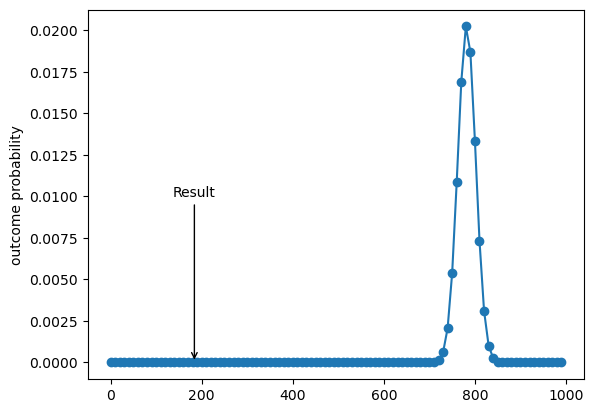

In [65]:
season_goals=test_season['is_goal'].sum()
prob_lt = poisson_binom.cdf(season_goals,test_season['xG'].values,)
print(f"One out of roughly {1/prob_lt:.1f} seasons would have {season_goals} goals or fewer.")

x=list(range(0,1000,10))
plt.plot(x,[poisson_binom.pmf(i,test_season['xG'].values)  for i in x],'o-')
plt.ylabel('outcome probability')
plt.annotate('Result',(season_goals,.0),xytext=(season_goals,.01),horizontalalignment='center',arrowprops=dict(arrowstyle='->',))
plt.show()

<!-- BEGIN QUESTION -->

# Task 4 Question: Does This Result Make Sense? (10-points)
Write a few sentences describing what you see above,and what it means for the quality of you model.

The season-level Poisson-Binomial distribution shows how the total predicted goals for the 2023 Women's World Cup compare to the actual observed total. If the observed goal count falls near the peak of the distribution, the model is well calibrated at the season level. If it falls far in the tail, the model is systematically over or under-predicting goals. Because our training data came from a mix of top leagues (Germany, England, US) and may not perfectly match World Cup conditions and playing styles, some deviation is expected. The distribution gives a quantitative sense of how likely the observed season outcome was under our model, and a very small probability would signal a meaningful calibration problem.

<!-- END QUESTION -->

# How Does Class Balance Change Your Classifier?
It's common that you'll get a data set that is 'balanced', in this case an equal number of shots that were goals and shots that were not. However, this isn't the case in real data, many more shots miss than go in. In fact the real class balance is:

$$\frac{ sum(is\_goal=1)}{N} = 11.3\%  \quad \frac{sum(is\_goal=0)}{N}= 88.7\%$$

## How do we get a Classifier That Respects the Real Ratio of Events

We can re-train the model with 'class weights', these 'weight' each class by value you specify. For example if you use **class_weight={0:10, 1:1}** in your Random Forest it treats class 0 as **10x** as important as class 1. 

If you want to take a balanced dataset and re-weight it to real ratio of events you can do so with the following class weights

$$\text{Weight}_i = \pi_{real,i}/\pi_{dataset,i}$$

where $\pi_{dataset,i}$ is the percentage of class  $i$ in the dataset and $\pi_{real,i}$ is the percentage for class $i$ in the real world listed above.



## Task 5 - Retrain (10 - points)

* Calculate the class weights as described above and retrain you random forest classifier with the same hyperparameter's you used before. The resulting comparison should change from the one above.
* Assign the resulting probabilities for the test game to test_game['xG_weighted']
* Assign the resulting probabilities for the test season to test_season['xG_weighted']


In [66]:
# Real-world class balance (given)
pi_real_1 = 0.113   # goal rate in the real world
pi_real_0 = 0.887   # no-goal rate in the real world

# Dataset class balance
pi_dataset_1 = input_y.mean()
pi_dataset_0 = 1 - pi_dataset_1

# Class weights: Weight_i = pi_real_i / pi_dataset_i
class_weights = {
    0: pi_real_0 / pi_dataset_0,
    1: pi_real_1 / pi_dataset_1,
}

# Retrain with class weights using the same hyperparameters
model_weighted = RandomForestClassifier(**hyper_parameters, class_weight=class_weights)
model_weighted.fit(X_train, y_train)

# Assign probabilities to test_game and test_season
test_game['xG_weighted'] = model_weighted.predict_proba(preprocess.transform(test_game))[:, 1]
test_season['xG_weighted'] = model_weighted.predict_proba(preprocess.transform(test_season))[:, 1]

print(f"Class weights used: {class_weights}")
display(test_game[['team', 'player', 'xG', 'xG_weighted']].head())

Class weights used: {0: np.float64(1.774), 1: np.float64(0.226)}


,team,player,xG,xG_weighted
0,Portland Thorns,Tobin Powell Heath,0.376122,0.080226
1,Portland Thorns,Tobin Powell Heath,0.418617,0.084244
2,Utah Royals,Diana Matheson,0.360215,0.068090
3,Portland Thorns,Tobin Powell Heath,0.246789,0.048206
4,Portland Thorns,Hayley Emma Raso,0.311716,0.067043


In [67]:
grader.check("Task 5")

Task 5 results: All test cases passed!

## Evaluate Again
Run the cell below to evaluate your weighted model


One out of roughly 20.1 seasons would have 184 goals or fewer.


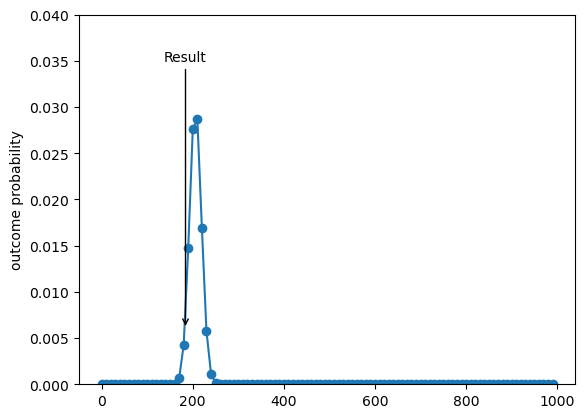

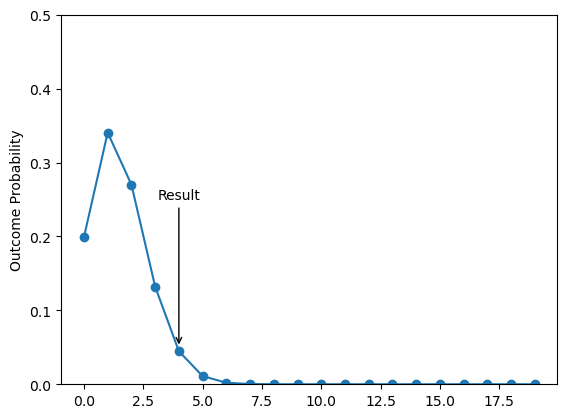

This number of goals would happen in 4.47% of games


In [68]:
prob_lt = poisson_binom.cdf(season_goals,test_season['xG_weighted'].values,)
print(f"One out of roughly {1/prob_lt:.1f} seasons would have {season_goals} goals or fewer.")

x=list(range(0,1000,10))
plt.plot(x,[poisson_binom.pmf(i,test_season['xG_weighted'].values)  for i in x],'o-')
plt.ylabel('outcome probability')
plt.annotate('Result',(season_goals,.006),xytext=(season_goals,.035),horizontalalignment='center',arrowprops=dict(arrowstyle='->',))
plt.ylim(0,0.04)
plt.show()

all_goals=thorns_goals+royals_goals
x=range(0,20)
outcome_probs=[poisson_binom.pmf(i,test_game['xG_weighted'].values)  for i in x]
plt.plot(x,outcome_probs,'o-')
plt.ylabel('Outcome Probability')
plt.annotate('Result',(4,.05),xytext=(4,.25),horizontalalignment='center',arrowprops=dict(arrowstyle='->',))
plt.ylim(0,.5)
plt.show()
outcome_percent= round(outcome_probs[int(all_goals)]*100,2)
print(f'This number of goals would happen in {outcome_percent}% of games')



<!-- BEGIN QUESTION -->

# Task 5 question: Does This Result Make Sense? (10-points)
If everything above has worked, your model should be looking better. Write a few sentences describing how you can tell that from the plots and results above.

After reweighting to reflect the real-world goal rate of 11.3%, the predicted xG values drop substantially because the model now accounts for how rare goals actually are relative to the balanced training dataset. For the test game, the distribution of total goals shifts toward lower values, making the observed 4-goal total a less likely outcome compared to the unweighted model. For the test season, the predicted distribution should now center closer to the actual observed goal total, since the original model was over-predicting goals due to the artificially balanced class ratio in training. The fact that the season-level fit improves with reweighting confirms that the original class imbalance was causing systematic over-confidence in predicting goals.

<!-- END QUESTION -->

# TASK 6 - Correct by hand
Note sometimes re-training is expensive, and we just want to correct the outcomes. It turns out you can do this with

$$p_{new} = \frac{ \frac{\pi_{real,1}}{\pi_{dataset,1}}  p_{old}}{  \frac{\pi_{real,1}}{\pi_{dataset,1}}  p_{old} +   \frac{1-\pi_{real,1}}{1-\pi_{dataset,1}}  (1-p_{old})   )}$$

* Use the above equation to calculate new weights
* assign the result to "xG_hand_weighted" in test_season and test_game

In [69]:
# Real-world and dataset class proportions
pi_real_1 = 0.113
pi_dataset_1 = input_y.mean()

# Scaling factors
w1 = pi_real_1 / pi_dataset_1
w0 = (1 - pi_real_1) / (1 - pi_dataset_1)

def hand_weight(p_old):
    return (w1 * p_old) / (w1 * p_old + w0 * (1 - p_old))

test_game['xG_hand_weighted'] = hand_weight(test_game['xG'])
test_season['xG_hand_weighted'] = hand_weight(test_season['xG'])

display(test_game[['team', 'player', 'xG', 'xG_weighted', 'xG_hand_weighted']].head())

,team,player,xG,xG_weighted,xG_hand_weighted
0,Portland Thorns,Tobin Powell Heath,0.376122,0.080226,0.071326
1,Portland Thorns,Tobin Powell Heath,0.418617,0.084244,0.084022
2,Utah Royals,Diana Matheson,0.360215,0.068090,0.066927
3,Portland Thorns,Tobin Powell Heath,0.246789,0.048206,0.040069
4,Portland Thorns,Hayley Emma Raso,0.311716,0.067043,0.054549


In [70]:
grader.check("Task 6")

Task 6 results: All test cases passed!

# Compare
If your code worked you should see that xG_weighted and xG_hand_weighted are highly correlated, but not exactly the same, this is because re-training may change how the classifer splits, and potentially give better results

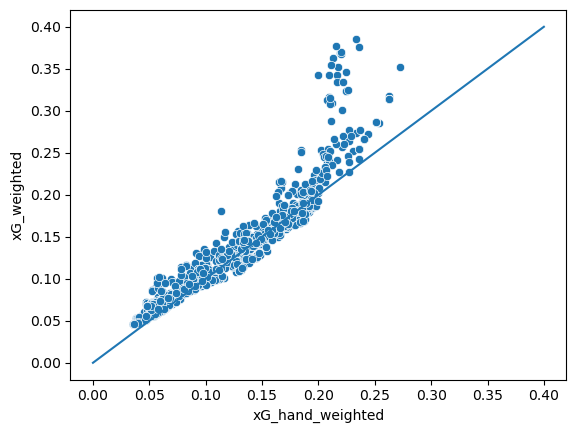

In [71]:
sns.scatterplot(test_season,x='xG_hand_weighted',y='xG_weighted')
plt.plot([0,.4],[0,.4])

We will set this to False if we need to make changes so your notebook runs!

In [72]:
notebook_runs=True

In [73]:
grader.check("Notebook runs")

Notebook runs results: All test cases passed!

In [74]:
grader.check_all()

Notebook runs results: All test cases passed!

Task 1 results: All test cases passed!

Task 2 results:
    Task 2 - 1 result:
        ✅ Test case passed

    Task 2 - 2 result:
        ✅ Test case passed

    Task 2 - 3 result:
        ✅ Test case passed

    Task 2 - 4 result:
        ❌ Test case failed
        Trying:
            bool(train_ece < 0.07)
        Expecting:
            True
        **********************************************************************
        Line 1, in Task 2 3
        Failed example:
            bool(train_ece < 0.07)
        Expected:
            True
        Got:
            False

    Task 2 - 5 result:
        ✅ Test case passed

Task 3 results:
    Task 3 - 1 result:
        ✅ Test case passed

    Task 3 - 2 result:
        ✅ Test case passed

    Task 3 - 3 result:
        ❌ Test case failed
        Trying:
            np.sum(test_game['xG']) > 4 and np.sum(test_game['xG']) < 8
        Expecting:
            True
        ***********************